# Initializing and Preprocessing
Load up experiment & annotations

In [1]:
import sys
sys.path.append("/tmp/pycharm_project_688/")
sys.path.append("/tmp/pycharm_project_688/src/")

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction, \
    preprocess_chunks_for_null_test_with_indoor
from preprocessing._segmentation import segment_null_classification, segment_windows
from visualization._visualization import swarm_plot_top_features

from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from visualization import plot_duration_histogram
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters

sample_rate = 50

In [3]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Ariane","Julian","Wiktoria"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]
print(experiment_dirs)

['../../data/phyphox/full recordings/Julian', '../../data/phyphox/full recordings/Ariane', '../../data/phyphox/full recordings/Wiktoria', '../../data/phyphox/full recordings/Ana-2']


Preprocess data

In [4]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

/tmp/pycharm_project_688/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mean 7.44 +/- 11.66
Mean 10.65 +/- 33.83


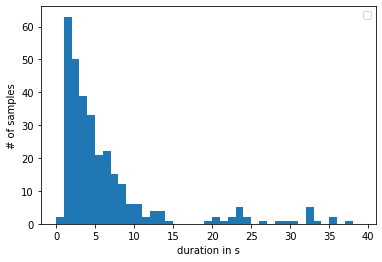

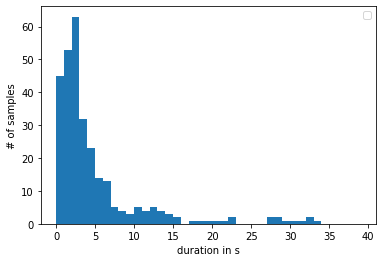

In [5]:
plot_duration_histogram(chunks["right"])
plot_duration_histogram(null_chunks["right"])

# append the action id to the dataframe
# we need to do this to be able to extract time series features later
# Preprocess data


if use_indoor:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test_with_indoor(chunks, null_chunks)
else:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)

### Segmentation

In [6]:
labels = y.loc[:, "label"].squeeze()


# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


# Multiclass classification

For the multi class classification we can reuse
- data loading
- preprocessing
- segmentation

We mainly need to:
- relabel the OCD segments with the y array
- do the segmentation for the ocd chunks again
- extract features again
- select and scale features again
- classify again
- visualize results again

In [7]:
# make sure we already run the segmentation for the binary classification earlier

assert len(labels_null_segmented) != 0

labels_ocd_multiclass = labels.reset_index(drop=True)

labels_ocd_multiclass = labels_ocd_multiclass.str.replace("  ", " ").str.strip()

assert set(labels_ocd_multiclass) == {'checking oven',
 'cleaning cup',
 'cleaning floor',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'drying hands',
 'pulling door',
 'pulling hair',
 'pushing door',
 'sitting down',
 'standing up',
 'walking',
 'washing hands'}

_, labels_ocd_segmented_multiclass = segment_windows(chunks_ocd, labels_ocd_multiclass.to_numpy(), window_size)



assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))
#14

In [8]:
# reuse chunks_ocd_segmented from the segmentation for the binary classifier
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

### Feature extraction for multi class OCD activities incl null

In [9]:
X_multi_class_classification = extract_timeseries_features(mulit_class_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


### Feature selection for multi class OCD activities incl null

In [10]:
impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)


In [11]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

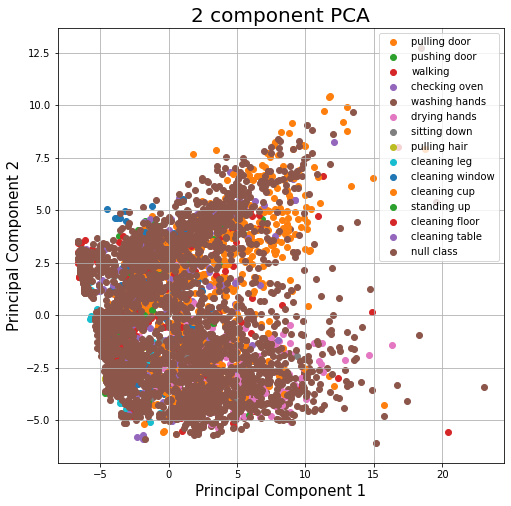

In [12]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

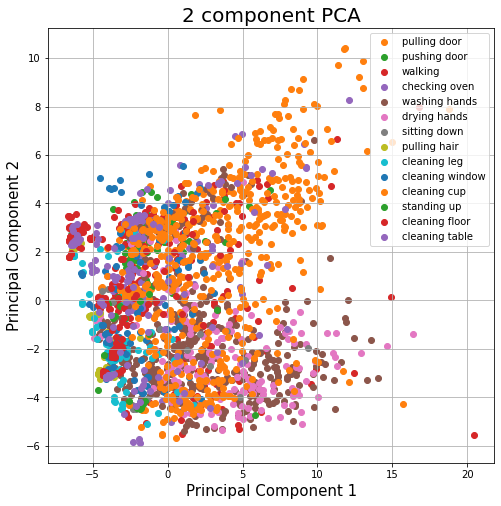

In [13]:
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique()[0:14], ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

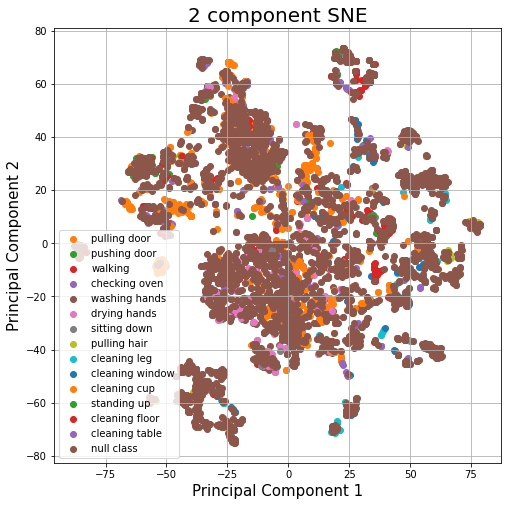

In [14]:
sne_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'], n_iter=1000,  perplexity=30)

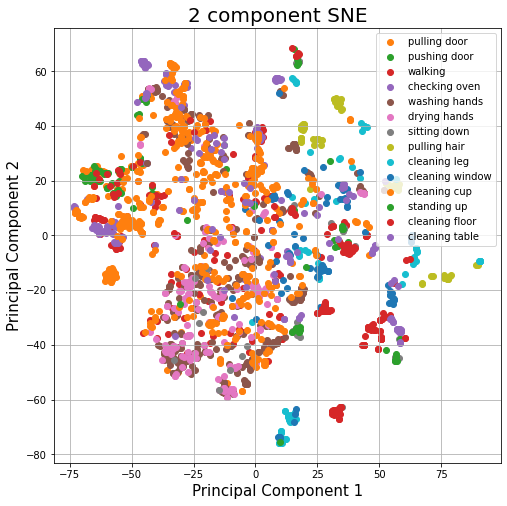

In [15]:
sne_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique()[0:14], ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'], n_iter=1000,  perplexity=30)

### Train models and score results

In [16]:
set(labels_multi_class_classification)

{'checking oven',
 'cleaning cup',
 'cleaning floor',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'drying hands',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',
 'sitting down',
 'standing up',
 'walking',
 'washing hands'}

In [17]:
print("Multi class classification with null class")
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)

Multi class classification with null class
Logistic Regression: 0.61 +/- 0.02
LDA: 0.57 +/- 0.04
LinearSVC: 0.60 +/- 0.02
CART: 0.49 +/- 0.06
Random Forest: 0.53 +/- 0.07
NB: 0.17 +/- 0.03
SVC: 0.59 +/- 0.04
XGBoost mult: 0.55 +/- 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn